In [1]:
import copy
import numpy as np
import pandas as pd
import scipy.stats
import dftools
import matplotlib.pyplot as plt

Welcome to JupyROOT 6.18/00


In [2]:
plt.style.use("cms")

In [3]:
_df_data = pd.read_hdf("fit_inputs.h5", "Data")
_df_mc = pd.read_hdf("fit_inputs.h5", "MC")
_df_mc_smooth = pd.read_hdf("fit_inputs.h5", "MCSmooth")
_df_mc_p4 = pd.read_hdf("fit_inputs.h5", "MCPoly4")
_df_mc_flat = pd.read_hdf("fit_inputs.h5", "MCFlat")

_df_data = _df_data.loc[~_df_data.index.duplicated(keep="first")]
_df_mc = _df_mc.loc[~_df_mc.index.duplicated(keep="first")]
_df_mc_smooth = _df_mc_smooth.loc[~_df_mc_smooth.index.duplicated(keep="first")]
_df_mc_p4 = _df_mc_p4.loc[~_df_mc_p4.index.duplicated(keep="first")]
_df_mc_flat = _df_mc_flat.loc[~_df_mc_flat.index.duplicated(keep="first")]

In [4]:
_df_mc.index.get_level_values("region").unique()


Index(['DoubleElectron', 'DoubleMuon', 'DoubleMuonMu', 'Monojet', 'MonojetQCD',
       'SingleElectron', 'SingleElectronMinus', 'SingleElectronPlus',
       'SingleElectronQCD', 'SingleMuon', 'SingleMuonMinus', 'SingleMuonMu',
       'SingleMuonMuQCD', 'SingleMuonPlus', 'SingleMuonQCD', 'SingleTau'],
      dtype='object', name='region')

## Modify dataframes

Alter the dataframes, for example, to make or break correlations between systematic uncertainties, remove variations from particular sources, or switch to polyfit smoothing or a flat systematic

### Rename nuisances

In [5]:
region_mapping = {
    "Monojet": {
        "metTrigMuonMultiplicitySyst": "metTrig0MuSyst",
        "metTrigRegionSyst": "metTrig{region}Syst",
    },
    "MonojetQCD": {
        "metTrigMuonMultiplicitySyst": "metTrig0MuSyst",
        "metTrigRegionSyst": "metTrig{region}Syst",
    },
    "SingleTau": {
        "metTrigMuonMultiplicitySyst": "metTrig0MuSyst",
        "metTrigRegionSyst": "metTrig{region}Syst",
    },
    "SingleMuon": {
        "metTrigMuonMultiplicitySyst": "metTrig1MuSyst",
        "metTrigRegionSyst": "metTrig{region}Syst",
    },
    "SingleMuonMinus": {
        "metTrigMuonMultiplicitySyst": "metTrig1MuSyst",
        "metTrigRegionSyst": "metTrig{region}Syst",
    },
    "SingleMuonPlus": {
        "metTrigMuonMultiplicitySyst": "metTrig1MuSyst",
        "metTrigRegionSyst": "metTrig{region}Syst",
    },
    "SingleMuonQCD": {
        "metTrigMuonMultiplicitySyst": "metTrig1MuSyst",
        "metTrigRegionSyst": "metTrig{region}Syst",
    },
    "DoubleMuon": {
        "metTrigMuonMultiplicitySyst": "metTrig2MuSyst",
        "metTrigRegionSyst": "metTrig{region}Syst",
    },
}

for region, mapping in region_mapping.items():
    _df_mc.loc[(region,)].rename(
        index={k+"Up": v.format(region=region)+"Up" for k, v in mapping.items()},
        level="variation", inplace=True
    )
    _df_mc.loc[(region,)].rename(
        index={k+"Down": v.format(region=region)+"Down" for k, v in mapping.items()},
        level="variation", inplace=True
    )

## Remove nuisances

In [6]:
region_process_variations = {
    ("Monojet", "ZJetsToNuNu"): ["lheScaleWeight", "lumi"],
    ("Monojet", "WJetsToLNu"): ["lheScaleWeight", "lumi"],
    ("SingleMuon", "WJetsToLNu"): ["lheScaleWeight", "lumi"],
    ("SingleMuonPlus", "WJetsToLNu"): ["lheScaleWeight", "lumi"],
    ("SingleMuonMinus", "WJetsToLNu"): ["lheScaleWeight", "lumi"],
    ("SingleElectron", "WJetsToLNu"): ["lheScaleWeight", "lumi"],
    ("SingleElectronPlus", "WJetsToLNu"): ["lheScaleWeight", "lumi"],
    ("SingleElectronMinus", "WJetsToLNu"): ["lheScaleWeight", "lumi"],
    ("DoubleMuon", "DYJetsToLL"): ["lheScaleWeight", "lumi"],
    ("DoubleElectron", "DYJetsToLL"): ["lheScaleWeight", "lumi"],
}

for (region, process), variations in region_process_variations.items():
    for variation in variations:
        for vtype in ["Up", "Down"]:
            try:
                _df_mc = _df_mc.drop([(region, process, variation+vtype)])
            except KeyError:
                pass


## Use gaussian filter smoothing

In [7]:
#variations = [
#    "pileup", "lhePdfWeight",
#]
#
#for variation in variations:
#    for vtype in ["Up", "Down"]:
#        _df_mc.loc[
#            (pd.IndexSlice[:], pd.IndexSlice[:], variation+vtype), :
#        ] = _df_mc_smooth.loc[
#            (pd.IndexSlice[:], pd.IndexSlice[:], variation+vtype), :
#        ]

## Use polyfit smoothing

In [8]:
region_process_variations = {
    ("Monojet", "ZJetsToNuNu"): ["jesTotal", "jerSF", "unclust", "lhePdfWeight", "pileup", "eleIdIsoTight"],
    ("Monojet", "WJetsToLNu"): ["jesTotal", "jerSF", "unclust", "lhePdfWeight", "pileup", "eleIdIsoTight"],
    ("SingleMuon", "WJetsToLNu"): ["jesTotal", "jerSF", "unclust", "lhePdfWeight", "pileup", "eleIdIsoTight"],
    ("SingleMuonPlus", "WJetsToLNu"): ["jesTotal", "jerSF", "unclust", "lhePdfWeight", "pileup", "eleIdIsoTight"],
    ("SingleMuonMinus", "WJetsToLNu"): ["jesTotal", "jerSF", "unclust", "lhePdfWeight", "pileup", "eleIdIsoTight"],
    ("SingleElectron", "WJetsToLNu"): ["jesTotal", "jerSF", "unclust", "lhePdfWeight", "pileup", "eleIdIsoTight"],
    ("SingleElectronPlus", "WJetsToLNu"): ["jesTotal", "jerSF", "unclust", "lhePdfWeight", "pileup", "eleIdIsoTight"],
    ("SingleElectronMinus", "WJetsToLNu"): ["jesTotal", "jerSF", "unclust", "lhePdfWeight", "pileup", "eleIdIsoTight"],
    ("DoubleMuon", "DYJetsToLL"): ["jesTotal", "jerSF", "unclust", "lhePdfWeight", "pileup", "eleIdIsoTight"],
    ("DoubleElectron", "DYJetsToLL"): ["jesTotal", "jerSF", "unclust", "lhePdfWeight", "pileup", "eleIdIsoTight"],
}

for (region, process), variations in region_process_variations.items():
    for variation in variations:
        for vtype in ["Up", "Down"]:
            _df_mc.loc[
                (region, process, variation+vtype, pd.IndexSlice[:]), :
            ] = _df_mc_p4.loc[
                (region, process, variation+vtype, pd.IndexSlice[:]), :
            ]


## Use flat systematic

In [9]:
process_variations = {
    ("Monojet", "MinorBkgs"): ["lheScaleWeight", "jesTotal", "jerSF", "unclust", "pileup", "eleIdIsoTight"],
    ("Monojet", "QCD"): ["lheScaleWeight", "jesTotal", "jerSF", "unclust", "pileup", "eleIdIsoTight"],
    ("SingleMuon", "MinorBkgs"): ["lheScaleWeight", "jesTotal", "jerSF", "unclust", "pileup", "eleIdIsoTight"],
    ("SingleMuon", "QCD"): ["jesTotal", "jerSF", "unclust", "pileup"],
    ("SingleMuonPlus", "MinorBkgs"): ["lheScaleWeight", "jesTotal", "jerSF", "unclust", "pileup", "eleIdIsoTight"],
    ("SingleMuonPlus", "QCD"): ["jesTotal", "jerSF", "unclust", "pileup"],
    ("SingleMuonMinus", "MinorBkgs"): ["lheScaleWeight", "jesTotal", "jerSF", "unclust", "pileup", "eleIdIsoTight"],
    ("SingleMuonMinus", "QCD"): ["jesTotal", "jerSF", "unclust", "pileup"],
    ("SingleElectron", "MinorBkgs"): ["lheScaleWeight", "jesTotal", "jerSF", "unclust", "pileup", "eleIdIsoTight"],
    ("SingleElectronPlus", "MinorBkgs"): ["lheScaleWeight", "jesTotal", "jerSF", "unclust", "pileup", "eleIdIsoTight"],
    ("SingleElectronMinus", "MinorBkgs"): ["lheScaleWeight", "jesTotal", "jerSF", "unclust", "pileup", "eleIdIsoTight"],
    ("DoubleMuon", "MinorBkgs"): ["lheScaleWeight", "jesTotal", "jerSF", "unclust", "pileup", "eleIdIsoTight"],
    ("DoubleElectron", "MinorBkgs"): ["lheScaleWeight", "jesTotal", "jerSF", "unclust", "pileup", "eleIdIsoTight"],
}

for (region, process), variations in process_variations.items():
    for variation in variations:
        for vtype in ["Up", "Down"]:
            _df_mc.loc[
                (region, process, variation+vtype, pd.IndexSlice[:]), :
            ] = _df_mc_flat.loc[
                (region, process, variation+vtype, pd.IndexSlice[:]), :
            ]

In [10]:
df_data = _df_data.unstack().unstack().loc[[
    ("MET", "Monojet"),
    ("MET", "MonojetQCD"),
    ("MET", "SingleMuon"),
    ("MET", "SingleMuonPlus"),
    ("MET", "SingleMuonMinus"),
    ("MET", "SingleMuonQCD"),
    ("MET", "DoubleMuon"),
    ("MET", "SingleTau"),
    ("SingleElectron", "SingleElectron"),
    ("SingleElectron", "SingleElectronPlus"),
    ("SingleElectron", "SingleElectronMinus"),
    ("SingleElectron", "SingleElectronQCD"),
    ("SingleElectron", "DoubleElectron"),
]].stack().stack().reset_index("trigger").drop("trigger", axis=1)
df_data.head(5)

count     sum_w    sum_ww
region  bin_min bin_max                              
Monojet 200.0   220.0    100530.0  100530.0  100530.0
        220.0   250.0    142330.0  142330.0  142330.0
        250.0   280.0    102427.0  102427.0  102427.0
        280.0   310.0     66110.0   66110.0   66110.0
        310.0   340.0     41367.0   41367.0   41367.0

In [11]:
df_mc = _df_mc.copy(deep=True)
df_mc.head(5)

sum_w      sum_ww
region         process    variation bin_min bin_max                         
DoubleElectron DYJetsToLL           200.0   220.0    1958.781793  449.582916
                                    220.0   250.0    3172.261468  645.801373
                                    250.0   280.0    2643.611845  375.874463
                                    280.0   310.0    1904.295307  139.346709
                                    310.0   340.0    1321.940298   55.436178

## Run fits

In [12]:
bin_min = df_data.index.get_level_values("bin_min").unique().values
bin_max = df_data.index.get_level_values("bin_max").unique().values
bin_edge = np.array(list(bin_min) + [bin_max[-1]])
bin_edge

array([ 200.,  220.,  250.,  280.,  310.,  340.,  370.,  400.,  430.,
        470.,  510.,  550.,  590.,  640.,  690.,  740.,  790.,  840.,
        900.,  960., 1020., 1090., 1160., 1250., 1400., 1550.])

In [13]:
df_mc.index.get_level_values("variation").unique()

Index(['', 'alphasDown', 'alphasUp', 'btagSFDown', 'btagSFUp', 'd1kewDown',
       'd1kewUp', 'd1kqcdDown', 'd1kqcdUp', 'd2kewwDown', 'd2kewwUp',
       'd2kewzDown', 'd2kewzUp', 'd2kqcdDown', 'd2kqcdUp', 'd3kewwDown',
       'd3kewwUp', 'd3kewzDown', 'd3kewzUp', 'd3kqcdDown', 'd3kqcdUp',
       'dkmixDown', 'dkmixUp', 'eleEnergyScaleDown', 'eleEnergyScaleUp',
       'eleIdIsoTightDown', 'eleIdIsoTightUp', 'eleIdIsoVetoDown',
       'eleIdIsoVetoUp', 'eleRecoDown', 'eleRecoUp', 'eleTrigDown',
       'eleTrigUp', 'jerSFDown', 'jerSFUp', 'jesTotalDown', 'jesTotalUp',
       'lhePdfWeightDown', 'lhePdfWeightUp', 'metTrigMuonMultiplicitySystDown',
       'metTrigMuonMultiplicitySystUp', 'metTrigReferenceTriggerSystDown',
       'metTrigReferenceTriggerSystUp', 'metTrigRegionSystDown',
       'metTrigRegionSystUp', 'muonIdLooseStatDown', 'muonIdLooseStatUp',
       'muonIdLooseSystDown', 'muonIdLooseSystUp', 'muonIdTightStatDown',
       'muonIdTightStatUp', 'muonIdTightSystDown', 'muonIdTi

In [16]:
bins = (bin_min, bin_max)

regions = {
    "Monojet":        ["ZJetsToNuNu", "WJetsToLNu", "MinorBkgs", "QCD"],
    "SingleMuon":     ["WJetsToLNu", "MinorBkgs", "QCD"],
    "SingleElectron": ["WJetsToLNu", "MinorBkgs"],
    "DoubleMuon":     ["DYJetsToLL", "MinorBkgs"],
    "DoubleElectron": ["DYJetsToLL", "MinorBkgs"],
}

config ={
    "regions": regions,
    "parameters": [
        {"name": "rZJetsToNuNu",   "value": 1., "limit": (0.5, 1.5), "fixed": False, "constraint": "free"},
        {"name": "rZJets",         "value": 1., "limit": (0.5, 1.5), "fixed": False, "constraint": "free"},
        {"name": "rWJetsToLNu",    "value": 1., "limit": (0.5, 1.5), "fixed": False, "constraint": "free"},
        
        {"name": "metTrig0MuSyst", "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        {"name": "metTrig1MuSyst", "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        {"name": "metTrig2MuSyst", "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        {"name": "metTrigReferenceTriggerSyst", "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
    ] + [
        {"name": "metTrig{}Syst".format(r), "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"}
        for r in ["Monojet", "MonojetQCD", "SingleMuon", "SingleMuonPlus", "SingleMuonMinus", "DoubleMuon", "SingleTau"] if r in regions.keys()
    ] + [
        {"name": "muonIdLooseSyst",  "value": 0., "limit": (-3., 3.),    "fixed": False, "constraint": "gaussian"},
        {"name": "muonIdLooseStat",  "value": 0., "limit": (-3., 3.),    "fixed": False, "constraint": "gaussian"},
        {"name": "muonIdTightSyst",  "value": 0., "limit": (-3., 3.),    "fixed": False, "constraint": "gaussian"},
        {"name": "muonIdTightStat",  "value": 0., "limit": (-3., 3.),    "fixed": False, "constraint": "gaussian"},
        {"name": "muonIsoLooseSyst", "value": 0., "limit": (-3., 3.),    "fixed": False, "constraint": "gaussian"},
        {"name": "muonIsoLooseStat", "value": 0., "limit": (-3., 3.),    "fixed": False, "constraint": "gaussian"},
        {"name": "muonIsoTightSyst", "value": 0., "limit": (-3., 3.),    "fixed": False, "constraint": "gaussian"},
        {"name": "muonIsoTightStat", "value": 0., "limit": (-3., 3.),    "fixed": False, "constraint": "gaussian"},
        {"name": "muonTrig",         "value": 0., "limit": (-3., 3.),    "fixed": False, "constraint": "gaussian"},
        {"name": "muonPtScale",      "value": 0., "limit": (-3., 3.),    "fixed": False, "constraint": "gaussian"},
        
        {"name": "eleIdIsoTight",  "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        {"name": "eleIdIsoVeto",   "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        {"name": "eleReco",        "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        {"name": "eleTrig",        "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        #{"name": "eleEnergyScale", "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        
        {"name": "photonIdLoose",       "value": 0., "limit": (-3., 3.),    "fixed": False, "constraint": "gaussian"},
        {"name": "photonPixelSeedVeto", "value": 0., "limit": (-3., 3.),    "fixed": False, "constraint": "gaussian"},
        #{"name": "photonEnergyScale",   "value": 0., "limit": (-3., 3.),    "fixed": False, "constraint": "gaussian"},
        
        {"name": "tauIdVLoose", "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        {"name": "tauIdTight",  "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        #{"name": "tauPtScale",  "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        {"name": "btagSF",      "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        {"name": "jesTotal",    "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        {"name": "jerSF",       "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        {"name": "unclust",     "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        
        {"name": "lumi",      "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        {"name": "pileup",    "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        {"name": "prefiring", "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        
        {"name": "d1kqcd",         "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        {"name": "d2kqcd",         "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        {"name": "d3kqcd",         "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        {"name": "d1kew",          "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        {"name": "d2kewz",         "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        {"name": "d2keww",         "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        {"name": "d3kewz",         "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        {"name": "d3keww",         "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        {"name": "dkmix",          "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        #{"name": "alphas",         "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        {"name": "lhePdfWeight",   "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        {"name": "lheScaleWeight", "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
    ] + [
        {"name": "{}_mcstat_bin{}".format(r, idx), "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gamma"}
        for r in regions.keys()
        for idx in range(len(bin_min))
    ],
    "scale_functions": {
        ("Monojet",        "ZJetsToNuNu"): "x, w, p: p['rZJets']*p['rZJetsToNuNu']",
        ("Monojet",        "WJetsToLNu"):  "x, w, p: p['rWJetsToLNu']",
        ("SingleMuon",     "WJetsToLNu"):  "x, w, p: p['rWJetsToLNu']",
        ("SingleElectron", "WJetsToLNu"):  "x, w, p: p['rWJetsToLNu']",
        ("DoubleMuon",     "DYJetsToLL"):  "x, w, p: p['rZJets']",
        ("DoubleElectron", "DYJetsToLL"):  "x, w, p: p['rZJets']",
    }
}

In [17]:
model = dftools.fitting.NLLModel(df_data, df_mc, bins, config, same_bin_widths=True)
minimizer = model.fit(migrad=False, minos=False)
minimizer.migrad(ncall=100_000)

------------------------------------------------------------------
| FCN = 1943                    |   Ncalls=33398 (33398 total)   |
| EDM = 8.68E-05 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------
|    | Name                        |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------------------------------
| 0  | rZJetsToNuNu                |   1.027   |   0.025   |            |            |   0.5   |   1.5   |       |
| 1  | rZJets                      |   1.03    |   0.03    |            |            |   0.5   |   1.5   |       |
| 2  | rWJetsToLNu                 |   1.13    |   0.04    |            |            |   0.5   |   1.5   |       |
| 3  | metTrig0MuSyst              |    0.0    |    1.0    |            |            |   -3    |    3    |       |
| 4  | metTrig1MuSyst              |    0.0    |    1.0    |            |            |   -3    |    3    |       |
| 5  | metTrig2MuSyst              |    0.0    |    1.0    |            |            |   -3    |    3    |       |
| 6  | metTrigReferenceTriggerSyst |   0.26    |   0.98    |            |            |   -3    |    3    |       |
| 7  | metTrigMonojetSyst          |    0.0    |    1.0    |            |            |   -3    |    3    |       |
| 8  | metTrigSingleMuonSyst       |    0.0    |    1.0    |            |            |   -3    |    3    |       |
| 9  | metTrigDoubleMuonSyst       |    0.0    |    1.0    |            |            |   -3    |    3    |       |
| 10 | muonIdLooseSyst             |  -0.000   |   0.982   |            |            |   -3    |    3    |       |
| 11 | muonIdLooseStat             |  -0.000   |   0.982   |            |            |   -3    |    3    |       |
| 12 | muonIdTightSyst             |   -0.16   |    0.96   |            |            |   -3    |    3    |       |
| 13 | muonIdTightStat             |   -0.29   |    0.96   |            |            |   -3    |    3    |       |
| 14 | muonIsoLooseSyst            |  -0.000   |   0.982   |            |            |   -3    |    3    |       |
| 15 | muonIsoLooseStat            |  -0.000   |   0.982   |            |            |   -3    |    3    |       |
| 16 | muonIsoTightSyst            |  -0.028   |   0.983   |            |            |   -3    |    3    |       |
| 17 | muonIsoTightStat            |   -0.09   |    0.98   |            |            |   -3    |    3    |       |
| 18 | muonTrig                    |    0.0    |    1.0    |            |            |   -3    |    3    |       |
| 19 | muonPtScale                 |   0.66    |   0.15    |            |            |   -3    |    3    |       |
| 20 | eleIdIsoTight               |    0.8    |    0.4    |            |            |   -3    |    3    |       |
| 21 | eleIdIsoVeto                |  -0.001   |   0.980   |            |            |   -3    |    3    |       |
| 22 | eleReco                     |   0.23    |   0.83    |            |            |   -3    |    3    |       |
| 23 | eleTrig                     |   0.22    |   0.46    |            |            |   -3    |    3    |       |
| 24 | photonIdLoose               |   0.000   |   0.982   |            |            |   -3

In [19]:
results = dftools.fitting.run_impacts(
    minimizer.parameters, "rZJetsToNuNu",
    nll_args=(df_data, df_mc, bins, config),
    nll_kwargs=dict(same_bin_widths=True),
    migrad_kwargs=dict(ncall=100_000),
    pysge_function="sge_submit",
    pysge_args=("zfit", "_ccsp_temp"),
    pysge_kwargs=dict(options="-q hep.q", dill_kw={"recurse": False}),
    params_guess=list(minimizer.args),
)

2019-09-22 02:53:40,853 - pysge.area - INFO - Creating paths in /vols/build/cms/sdb15/ZinvWidth/zinv-notebooks/notebooks/background_prediction/wjets/_ccsp_temp/tpd_20190922_025340_53yfknrd


2019-09-22 02:53:46,338 - pysge.submitter - INFO - Submitted 9824541.1-75:1


## Draw contributions to NLL with various parameters

In [44]:
model = dftools.fitting.NLLModel(df_data, df_mc, bins, config, same_bin_widths=True)
minimizer = model.fit(asimov=True, migrad=False, minos=False)

------------------------------------------------------------------
| FCN = 1791                    |     Ncalls=841 (841 total)     |
| EDM = 5.69E-05 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     False     |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     True      |     True      |   False   |   False   | False  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------
|    | Name                        |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------------------------------
| 0  | rZJetsToNuNu                |    1.0    |    0.0    |            |            |   0.5   |   1.5   |       |
| 1  | rZJets                      |    1.0    |    0.0    |            |            |   0.5   |   1.5   |       |
| 2  | rWJetsToLNu                 |    1.0    |    0.0    |            |            |   0.5   |   1.5   |       |
| 3  | rWJetsToLNuQCD              |    1.0    |    0.0    |            |            |   0.5   |   1.5   |       |
| 4  | metTrig0MuSyst              |     0     |     0     |            |            |   -3    |    3    |       |
| 5  | metTrig1MuSyst              |     0     |     0     |            |            |   -3    |    3    |       |
| 6  | metTrig2MuSyst              |     0     |     0     |            |            |   -3    |    3    |       |
| 7  | metTrigReferenceTriggerSyst |     0     |     0     |            |            |   -3    |    3    |       |
| 8  | metTrigMonojetSyst          |     0     |     0     |            |            |   -3    |    3    |       |
| 9  | metTrigSingleMuonSyst       |     0     |     0     |            |            |   -3    |    3    |       |
| 10 | metTrigSingleElectronSyst   |     0     |     0     |            |            |   -3    |    3    |       |
| 11 | metTrigDoubleMuonSyst       |     0     |     0     |            |            |   -3    |    3    |       |
| 12 | metTrigDoubleElectronSyst   |     0     |     0     |            |            |   -3    |    3    |       |
| 13 | muonIdLooseSyst             |     0     |     0     |            |            |   -3    |    3    |       |
| 14 | muonIdLooseStat             |     0     |     0     |            |            |   -3    |    3    |       |
| 15 | muonIdTightSyst             |  0.000E1  |  0.000E1  |            |            |   -3    |    3    |       |
| 16 | muonIdTightStat             |  0.000E1  |  0.000E1  |            |            |   -3    |    3    |       |
| 17 | muonIsoLooseSyst            |     0     |     0     |            |            |   -3    |    3    |       |
| 18 | muonIsoLooseStat            |     0     |     0     |            |            |   -3    |    3    |       |
| 19 | muonIsoTightSyst            |     0     |     0     |            |            |   -3    |    3    |       |
| 20 | muonIsoTightStat            |     0     |     0     |            |            |   -3    |    3    |       |
| 21 | muonTrig                    |     0     |     0     |            |            |   -3    |    3    |       |
| 22 | muonPtScale                 |  0.000E1  |  0.000E1  |            |            |   -3    |    3    |       |
| 23 | eleIdIsoTight               |  0.000E1  |  0.000E1  |            |            |   -3    |    3    |       |
| 24 | eleIdIsoVeto                |     0     |     0     |            |            |   -3

In [45]:
minimizer.migrad()

------------------------------------------------------------------
| FCN = 1791                    |    Ncalls=3549 (4390 total)    |
| EDM = 5.26E-06 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     False     |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     True      |     True      |   False   |   False   | False  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------
|    | Name                        |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------------------------------
| 0  | rZJetsToNuNu                |    1.0    |    0.0    |            |            |   0.5   |   1.5   |       |
| 1  | rZJets                      |    1.0    |    0.0    |            |            |   0.5   |   1.5   |       |
| 2  | rWJetsToLNu                 |    1.0    |    0.0    |            |            |   0.5   |   1.5   |       |
| 3  | rWJetsToLNuQCD              |    1.0    |    0.0    |            |            |   0.5   |   1.5   |       |
| 4  | metTrig0MuSyst              |     0     |     0     |            |            |   -3    |    3    |       |
| 5  | metTrig1MuSyst              |     0     |     0     |            |            |   -3    |    3    |       |
| 6  | metTrig2MuSyst              |     0     |     0     |            |            |   -3    |    3    |       |
| 7  | metTrigReferenceTriggerSyst |     0     |     0     |            |            |   -3    |    3    |       |
| 8  | metTrigMonojetSyst          |     0     |     0     |            |            |   -3    |    3    |       |
| 9  | metTrigSingleMuonSyst       |     0     |     0     |            |            |   -3    |    3    |       |
| 10 | metTrigSingleElectronSyst   |     0     |     0     |            |            |   -3    |    3    |       |
| 11 | metTrigDoubleMuonSyst       |     0     |     0     |            |            |   -3    |    3    |       |
| 12 | metTrigDoubleElectronSyst   |     0     |     0     |            |            |   -3    |    3    |       |
| 13 | muonIdLooseSyst             |     0     |     0     |            |            |   -3    |    3    |       |
| 14 | muonIdLooseStat             |     0     |     0     |            |            |   -3    |    3    |       |
| 15 | muonIdTightSyst             |  0.000E1  |  0.000E1  |            |            |   -3    |    3    |       |
| 16 | muonIdTightStat             |  0.000E1  |  0.000E1  |            |            |   -3    |    3    |       |
| 17 | muonIsoLooseSyst            |     0     |     0     |            |            |   -3    |    3    |       |
| 18 | muonIsoLooseStat            |     0     |     0     |            |            |   -3    |    3    |       |
| 19 | muonIsoTightSyst            |     0     |     0     |            |            |   -3    |    3    |       |
| 20 | muonIsoTightStat            |     0     |     0     |            |            |   -3    |    3    |       |
| 21 | muonTrig                    |     0     |     0     |            |            |   -3    |    3    |       |
| 22 | muonPtScale                 |  0.000E1  |  0.000E1  |            |            |   -3    |    3    |       |
| 23 | eleIdIsoTight               |  0.000E1  |  0.000E1  |            |            |   -3    |    3    |       |
| 24 | eleIdIsoVeto                |     0     |     0     |            |            |   -3

In [32]:
minimizer.minos("rZJetsToNuNu")

-------------------------------------------------
|  rZJetsToNuNu   |            Valid            |
-------------------------------------------------
|      Error      |    -0.045    |     0.024    |
|      Valid      |     True     |     True     |
|    At Limit     |    False     |    False     |
|     Max FCN     |    False     |    False     |
|     New Min     |    False     |    False     |
-------------------------------------------------

AttributeError: 'iminuit._libiminuit.Minuit' object has no attribute 'mprofile'

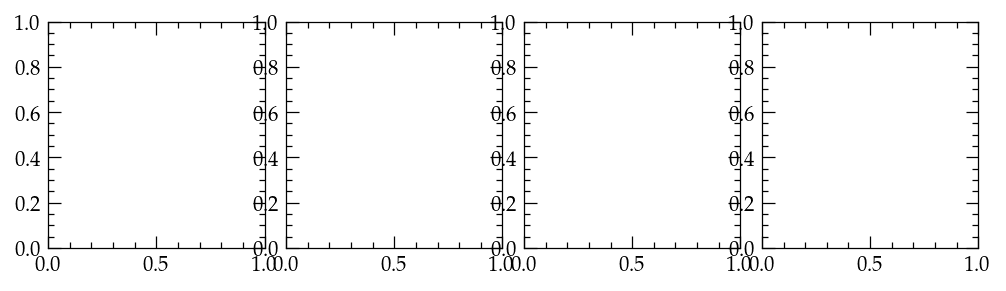

In [33]:
parameters = [
    "rZJetsToNuNu", "rZJets", "rWJetsToLNu", "rWJetsToLNuQCD",
]
nrows = (len(parameters)-1)//4 + 1

fix, ax = plt.subplots(
    figsize=(8, 2*nrows), dpi=150,
    nrows=nrows, ncols=4,
    sharex=False, sharey=False,
    gridspec_kw={"hspace": 0.1, "wspace": 0.1},
)

for idx, param in enumerate(parameters):
    p, fp = minimizer.profile(param, subtract_min=True)
    
    row = idx//4
    col = idx%4
    ax[row,col].plot(p, fp)
    ax[row,col].legend([], [], title=param)

In [ ]:
bf = minimizer.values

## Monojet and SingleMuon region only - test

In [23]:
bins = (bin_min, bin_max)

regions = {
    "Monojet":           ["ZJetsToNuNu", "WJetsToLNu", "MinorBkgs", "QCD"],
    #"SingleMuon":        ["WJetsToLNu", "MinorBkgs", "QCD"],
}

config ={
    "regions": regions,
    "parameters": [
        {"name": "rZJetsToNuNu",   "value": 1., "limit": (0.1, 10.), "fixed": False, "constraint": "free"},
        {"name": "rWJetsToLNu",    "value": 1., "limit": (0.1, 10.), "fixed": False, "constraint": "free"},
        
        #{"name": "metTrigMuonMultiplicitySyst", "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        {"name": "metTrig0MuSyst", "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        {"name": "metTrig1MuSyst", "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        {"name": "metTrig2MuSyst", "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        {"name": "metTrigReferenceTriggerSyst", "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        #{"name": "metTrigRegionSyst",           "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
    ] + [
        {"name": "metTrig{}Syst".format(r), "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"}
        for r in regions.keys()
    ] + [
        {"name": "muonIdLooseSyst",  "value": 0., "limit": (-3., 3.),    "fixed": False, "constraint": "gaussian"},
        {"name": "muonIdLooseStat",  "value": 0., "limit": (-3., 3.),    "fixed": False, "constraint": "gaussian"},
        {"name": "muonIdTightSyst",  "value": 0., "limit": (-3., 3.),    "fixed": False, "constraint": "gaussian"},
        {"name": "muonIdTightStat",  "value": 0., "limit": (-3., 3.),    "fixed": False, "constraint": "gaussian"},
        {"name": "muonIsoLooseSyst", "value": 0., "limit": (-3., 3.),    "fixed": False, "constraint": "gaussian"},
        {"name": "muonIsoLooseStat", "value": 0., "limit": (-3., 3.),    "fixed": False, "constraint": "gaussian"},
        {"name": "muonIsoTightSyst", "value": 0., "limit": (-3., 3.),    "fixed": False, "constraint": "gaussian"},
        {"name": "muonIsoTightStat", "value": 0., "limit": (-3., 3.),    "fixed": False, "constraint": "gaussian"},
        {"name": "muonTrig",         "value": 0., "limit": (-3., 3.),    "fixed": False, "constraint": "gaussian"},
        {"name": "muonPtScale",      "value": 0., "limit": (-3., 3.),    "fixed": False, "constraint": "gaussian"},
        
        {"name": "eleIdIsoTight",  "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        {"name": "eleIdIsoVeto",   "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        {"name": "eleReco",        "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        {"name": "eleTrig",        "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        #{"name": "eleEnergyScale", "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        
        {"name": "photonIdLoose",       "value": 0., "limit": (-3., 3.),    "fixed": False, "constraint": "gaussian"},
        {"name": "photonPixelSeedVeto", "value": 0., "limit": (-3., 3.),    "fixed": False, "constraint": "gaussian"},
        #{"name": "photonEnergyScale",   "value": 0., "limit": (-3., 3.),    "fixed": False, "constraint": "gaussian"},
        
        {"name": "tauIdVLoose", "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        {"name": "tauIdTight",  "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        #{"name": "tauPtScale",  "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        {"name": "btagSF",      "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        {"name": "jesTotal",    "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        {"name": "jerSF",       "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        {"name": "unclust",     "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        
        {"name": "lumi",      "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        {"name": "pileup",    "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        {"name": "prefiring", "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        
        {"name": "d1kqcd",         "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        {"name": "d2kqcd",         "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        {"name": "d3kqcd",         "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        {"name": "d1kew",          "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        {"name": "d2kewz",         "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        {"name": "d2keww",         "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        {"name": "d3kewz",         "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        {"name": "d3keww",         "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        {"name": "dkmix",          "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        #{"name": "alphas",         "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        {"name": "lhePdfWeight",   "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        {"name": "lheScaleWeight", "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
    ] + [
        {"name": "{}_mcstat_bin{}".format(r, idx), "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gamma"}
        for r in regions.keys()
        for idx in range(len(bin_min))
    ],
    "scale_functions": {
        ("Monojet",        "ZJetsToNuNu"): "x, p: p['rZJetsToNuNu']",
        ("Monojet",        "WJetsToLNu"):  "x, p: p['rWJetsToLNu']",
        ("SingleMuon",     "WJetsToLNu"):  "x, p: p['rWJetsToLNu']",
    }
}

In [24]:
model = dftools.fitting.NLLModel(df_data, df_mc, bins, config, same_bin_widths=True)
minimizer = model.fit(migrad=False, minos=False)
minimizer.migrad(ncall=100_000)

------------------------------------------------------------------
| FCN = 536.5                   |   Ncalls=12926 (12926 total)   |
| EDM = 9.49E-05 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------
|   | Name                        |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
-----------------------------------------------------------------------------------------------------------------
| 0 | rZJetsToNuNu                |   0.97    |   0.08    |            |            |   0.1   |   10    |       |
| 1 | rWJetsToLNu                 |   1.36    |   0.13    |            |            |   0.1   |   10    |       |
| 2 | metTrig0MuSyst              |    0.0    |    1.0    |            |            |   -3    |    3    |       |
| 3 | metTrig1MuSyst              |    0.0    |    1.0    |            |            |   -3    |    3    |       |
| 4 | metTrig2MuSyst              |    0.0    |    1.0    |            |            |   -3    |    3    |       |
| 5 | metTrigReferenceTriggerSyst |   0.15    |   0.98    |            |            |   -3    |    3    |       |
| 6 | metTrigMonojetSyst          |    0.0    |    1.0    |            |            |   -3    |    3    |       |
| 7 | muonIdLooseSyst             |  -0.000   |   0.982   |            |            |   -3    |    3    |       |
| 8 | muonIdLooseStat             |   0.000   |   0.982   |            |            |   -3    |    3    |       |
| 9 | muonIdTightSyst             |   0.000   |   0.982   |            |            |   -3    |    3    |       |
| 10| muonIdTightStat             |   0.000   |   0.982   |            |            |   -3    |    3    |       |
| 11| muonIsoLooseSyst            |  -0.000   |   0.982   |            |            |   -3    |    3    |       |
| 12| muonIsoLooseStat            |   0.000   |   0.982   |            |            |   -3    |    3    |       |
| 13| muonIsoTightSyst            |  -0.000   |   0.982   |            |            |   -3    |    3    |       |
| 14| muonIsoTightStat            |  -0.000   |   0.982   |            |            |   -3    |    3    |       |
| 15| muonTrig                    |    0.0    |    1.0    |            |            |   -3    |    3    |       |
| 16| muonPtScale                 |    0.6    |    0.6    |            |            |   -3    |    3    |       |
| 17| eleIdIsoTight               |  -0.004   |   0.982   |            |            |   -3    |    3    |       |
| 18| eleIdIsoVeto                |  -0.000   |   0.982   |            |            |   -3    |    3    |       |
| 19| eleReco                     |  -0.000   |   0.982   |            |            |   -3    |    3    |       |
| 20| eleTrig                     |    0.0    |    1.0    |            |            |   -3    |    3    |       |
| 21| photonIdLoose               |   0.000   |   0.982   |            |            |   -3    |    3    |       |
| 22| photonPixelSeedVeto         |  -0.000   |   0.982   |            |            |   -3    |    3    |       |
| 23| tauIdVLoose                 |   0.05    |   0.99    |            |            |   -3    |    3    |       |
| 24| tauIdTight                  |  -0.008   |   0.981   |            |            |   -3    |    3    |       |
| 25

In [25]:
minimizer.minos("rZJetsToNuNu")

-------------------------------------------------
|  rZJetsToNuNu   |            Valid            |
-------------------------------------------------
|      Error      |    -0.08     |     0.08     |
|      Valid      |     True     |     True     |
|    At Limit     |    False     |    False     |
|     Max FCN     |    False     |    False     |
|     New Min     |    False     |    False     |
-------------------------------------------------

In [26]:
minimizer.minos("rWJetsToLNu")

-------------------------------------------------
|  rZJetsToNuNu   |            Valid            |
-------------------------------------------------
|      Error      |    -0.08     |     0.08     |
|      Valid      |     True     |     True     |
|    At Limit     |    False     |    False     |
|     Max FCN     |    False     |    False     |
|     New Min     |    False     |    False     |
-------------------------------------------------
-------------------------------------------------
|   rWJetsToLNu   |            Valid            |
-------------------------------------------------
|      Error      |    -0.13     |     0.14     |
|      Valid      |     True     |     True     |
|    At Limit     |    False     |    False     |
|     Max FCN     |    False     |    False     |
|     New Min     |    False     |    False     |
-------------------------------------------------

In [27]:
minimizer.minos("muonPtScale")

-------------------------------------------------
|  rZJetsToNuNu   |            Valid            |
-------------------------------------------------
|      Error      |    -0.08     |     0.08     |
|      Valid      |     True     |     True     |
|    At Limit     |    False     |    False     |
|     Max FCN     |    False     |    False     |
|     New Min     |    False     |    False     |
-------------------------------------------------
-------------------------------------------------
|   rWJetsToLNu   |            Valid            |
-------------------------------------------------
|      Error      |    -0.13     |     0.14     |
|      Valid      |     True     |     True     |
|    At Limit     |    False     |    False     |
|     Max FCN     |    False     |    False     |
|     New Min     |    False     |    False     |
-------------------------------------------------
-------------------------------------------------
|   muonPtScale   |            Valid            |
-------------------------------------------------
|      Error      |     -1.4     |      0.4     |
|      Valid      |     True     |     True     |
|    At Limit     |    False     |    False     |
|     Max FCN     |    False     |    False     |
|     New Min     |    False     |    False     |
-------------------------------------------------